# Make compressed plots of mouse kinematics across age

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.plotting import format_plots, figure, save_factory, PlotConfig

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig1-kinematics", tight_layout=False)

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_syllable_df_v00.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19586258 entries, 0 to 19586257
Data columns (total 44 columns):
 #   Column          Dtype         
---  ------          -----         
 0   experiment      string        
 1   file            string        
 2   uuid            string        
 3   date            datetime64[us]
 4   age             int64         
 5   syllables       int16         
 6   pc_00           float32       
 7   pc_01           float32       
 8   pc_02           float32       
 9   pc_03           float32       
 10  pc_04           float32       
 11  pc_05           float32       
 12  pc_06           float32       
 13  pc_07           float32       
 14  pc_08           float32       
 15  pc_09           float32       
 16  true_depth      float32       
 17  session_name    string        
 18  subject_name    string        
 19  timestamps      float32       
 20  raw_timestamps  float32       
 21  area_mm         float32       
 22  area_px         

In [5]:
def compute_kinematics(df):
    mean_angular_speed = (df["angle"].diff(3) / 3).abs().mean() * 30
    mean_velocity = (
        df["velocity_2d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    mean_3d_velocity = (
        df["velocity_3d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    return pd.Series(dict(angular=mean_angular_speed, two_d=mean_velocity, three_d=mean_3d_velocity))

In [6]:
kin_df = df.groupby(['age', 'uuid'], sort=False)[['angle', 'velocity_2d_mm', 'velocity_3d_mm']].apply(compute_kinematics)

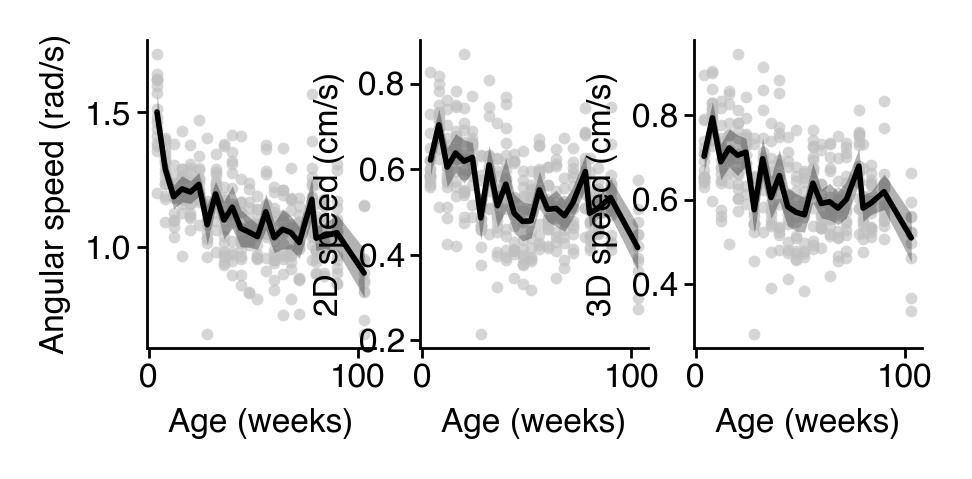

In [7]:
ylabel_map = dict(
    angular="Angular speed (rad/s)", two_d="2D speed (cm/s)", three_d="3D speed (cm/s)"
)

fig, ax = plt.subplots(1, 3, figsize=(2.5, 1), sharex=True)
for a, k in zip(ax.flat, ("angular", "two_d", "three_d")):
    a = sns.scatterplot(
        data=kin_df.reset_index(),
        x="age",
        y=k,
        linewidths=0,
        s=4.5,
        zorder=-1,
        color="silver",
        ax=a,
        alpha=0.65,
    )
    a = sns.lineplot(
        data=kin_df.reset_index(),
        x="age",
        y=k,
        errorbar=("se", 2),
        err_kws=dict(lw=0, alpha=0.3),
        color="k",
        ax=a,
    )
    a.set(ylabel=ylabel_map[k], xlabel="Age (weeks)")
sns.despine()
saver(fig, "speeds-over-age");

In [8]:
size_df = df.groupby(['age', 'uuid'], sort=False)[['height_ave_mm', 'area_mm']].mean()
size_df['area_mm'] = size_df['area_mm'] / 100

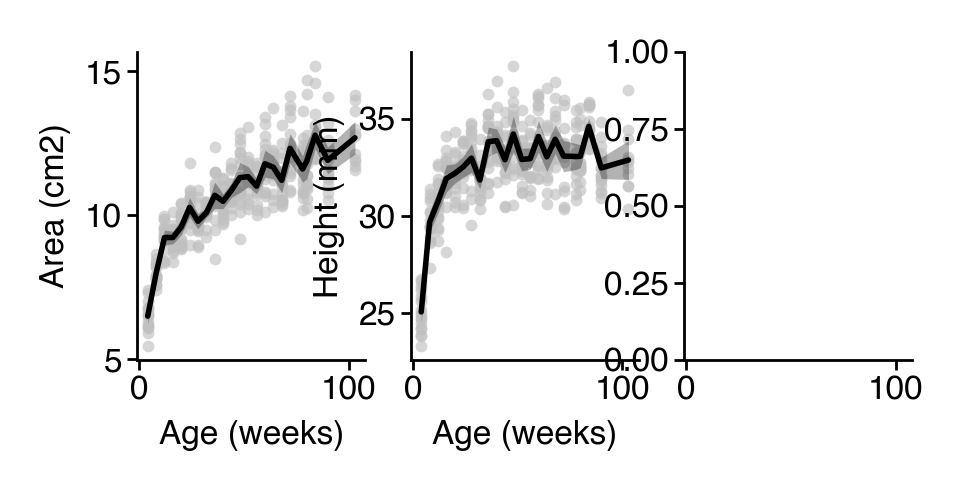

In [9]:
ylabel_map = dict(area_mm="Area (cm2)", height_ave_mm="Height (mm)")

fig, ax = plt.subplots(1, 3, figsize=(2.5, 1), sharex=True)
for a, k in zip(
    ax.flat,
    (
        "area_mm",
        "height_ave_mm",
    ),
):
    a = sns.scatterplot(
        data=size_df.reset_index(),
        x="age",
        y=k,
        linewidths=0,
        s=4.5,
        zorder=-1,
        color="silver",
        ax=a,
        alpha=0.65,
    )
    a = sns.lineplot(
        data=size_df.reset_index(),
        x="age",
        y=k,
        errorbar=("se", 2),
        err_kws=dict(lw=0, alpha=0.3),
        color="k",
        ax=a,
    )
    a.set(ylabel=ylabel_map[k], xlabel="Age (weeks)")
sns.despine()
saver(fig, "sizes-over-age");

## Linear model

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score

In [18]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression(),
)

In [ ]:
age = kin_df.index.get_level_values('age')

scores = []
for i in range(50):
    preds = cross_val_predict(pipeline, kin_df, age, cv=KFold(shuffle=True, random_state=i))
    scores.append(r2_score(age, preds))

np.random.seed(0)
shuff_scores = []
for i in range(50):
    age = kin_df.index.get_level_values('age').to_numpy()
    np.random.shuffle(age)
    
    preds = cross_val_predict(pipeline, kin_df, age, cv=KFold(shuffle=True, random_state=i))
    shuff_scores.append(r2_score(age, preds))

/tmp/ipykernel_876/3652523005.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Shuffle", "Observed"], ylabel="Heldout R2")


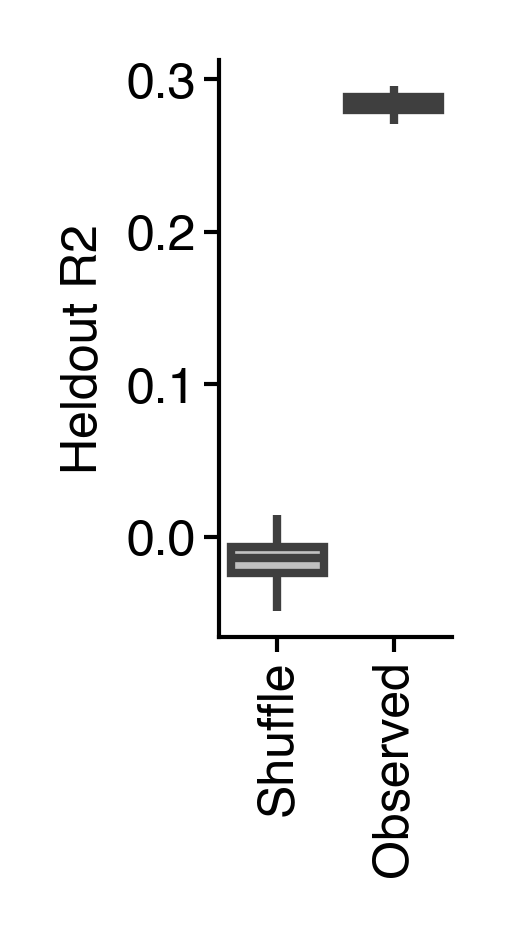

In [38]:
fig = figure(0.5, 1.25)
ax = sns.boxplot([shuff_scores, scores], showcaps=False, showfliers=False, color='silver')
ax.set(xticklabels=["Shuffle", "Observed"], ylabel="Heldout R2")
plt.xticks(rotation=90)
sns.despine()
saver(fig, "kinematics-linear-regression");